*This notebook was created by Andrei Trebushinin (trebandrej@gmail.com) and Svitozar Serkez. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). August 2019.*

## PFS tutorial N2. Coherent radiation module and `RadiationField` object.
OCELOT has the RadiationField object which represents a 3D electric field distribution, initially in space-time domain

In [1]:
%matplotlib inline
import logging
import ocelot
from ocelot.common.globals import *
from ocelot.optics.wave import RadiationField, dfl_waistscan
from ocelot.optics.wave import imitate_sase_dfl, wigner_dfl, dfl_waistscan, generate_gaussian_dfl, dfl_ap_rect, dfl_ap_circ, dfl_interp, wigner_dfl, wigner_smear, dfl_chirp_freq
from ocelot.gui.dfl_plot import plot_dfl, plot_wigner, plot_dfl_waistscan
from copy import deepcopy
from ocelot import ocelog

ocelog.setLevel(logging.WARNING)
#ocelog.setLevel(logging.DEBUG)
#ocelog.setLevel(logging.INFO)

initializing ocelot...


### Contents
1. [Generating Gaussian RadiationField](#gen_dfl)
2. [Plotting](#plot_radiation_field)
3. [Focusing](#focus_radiation_field)
4. [Propagating](#prop_radiation_field)
5. [Aperturing](#dif_on_ap)
6. [Interpolating](#dfl_interp)
7. [Space-frequency analysis](#SF_analysis)
    * [Wigner distribution](#Wigner)
    * [Compress the chirped pulse](#Compression)
    * [Spectrogram](#Spectrogram)


In [2]:
dfl = RadiationField()
help(RadiationField)

Help on class RadiationField in module ocelot.optics.wave:

class RadiationField(builtins.object)
 |  RadiationField(shape=(0, 0, 0))
 |  
 |  3d or 2d coherent radiation distribution, *.fld variable is the same as Genesis dfl structure
 |  
 |  Methods defined here:
 |  
 |  E(self)
 |      energy in the pulse [J]
 |  
 |  Lx(self)
 |      full transverse horizontal mesh size
 |  
 |  Ly(self)
 |      full transverse vertical mesh size
 |  
 |  Lz(self)
 |      full longitudinal mesh size
 |  
 |  Nx(self)
 |      number of points in x
 |  
 |  Ny(self)
 |      number of points in y
 |  
 |  Nz(self)
 |      number of points in z
 |  
 |  __getitem__(self, i)
 |  
 |  __init__(self, shape=(0, 0, 0))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setitem__(self, i, fld)
 |  
 |  ang_z_onaxis(self)
 |      on-axis phase
 |  
 |  coh(self, jit=0)
 |      calculates degree of transverse coherence
 |      consider downsampling the field first
 |  
 |  cop

<a id='gen_dfl'></a>
### Generating Gaussian RadiationField

We will demonstrate capabilities of this object using a model gaussian beam. The 3D gaussian beam radiation pulse can be defined with the following arguments:

In [3]:
help(generate_gaussian_dfl)

E_pohoton = 8000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'shape':(301,301,10),           #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(500e-6,500e-6,1e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(3e-6,10e-6,0.1e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'power_center':(0,0,None),     #(x,y,z) [m] - position of the radiation distribution
        'power_angle':(0,0),           #(x,y) [rad] - angle of further radiation propagation
        'power_waistpos':(-5,-15),     #(Z_x,Z_y) [m] downstrean location of the waist of the beam
        'wavelength':None,             #central frequency of the radiation, if different from xlamds
        'zsep':None,                   #distance between slices in z as zsep*xlamds
        'freq_chirp':0,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        'en_pulse':None,               #total energy or max power of the pulse, use only one
        'power':1e6,
        }
dfl = generate_gaussian_dfl(**kwargs);

Help on function generate_gaussian_dfl in module ocelot.optics.wave:

generate_gaussian_dfl(xlamds=1e-09, shape=(51, 51, 100), dgrid=(0.001, 0.001, 5e-05), power_rms=(0.0001, 0.0001, 5e-06), power_center=(0, 0, None), power_angle=(0, 0), power_waistpos=(0, 0), wavelength=None, zsep=None, freq_chirp=0, en_pulse=None, power=1000000.0, **kwargs)
    generates RadiationField object
    narrow-bandwidth, paraxial approximations
    
    xlamds [m] - central wavelength
    shape (x,y,z) - shape of field matrix (reversed) to dfl.fld
    dgrid (x,y,z) [m] - size of field matrix
    power_rms (x,y,z) [m] - rms size of the radiation distribution (gaussian)
    power_center (x,y,z) [m] - position of the radiation distribution
    power_angle (x,y) [rad] - angle of further radiation propagation
    power_waistpos (x,y) [m] downstrean location of the waist of the beam
    wavelength [m] - central frequency of the radiation, if different from xlamds
    zsep (integer) - distance between slices in z 

The RadiationField object is a 3D data cube in dfl.fld attribute (numpy array) with a ```dfl.fld.shape = dfl.shape() = (Nz, Nx, Ny)``` and a grid step for each axis ```dfl.dx , dfl.dy , dfl.dz``` so that ```dgrid[0], dgrid[1], dgrid[2] = dx*Nx, dy*Ny, dz*Nz```.

We created the gaussian beam with location of its horizontal waist at -5 meters and vertical waist at -15 meters location (wavefront is divergent now)

<a id='plot_radiation_field'></a>
## Plotting

To visulize the radiation one can use ```plot_dfl()``` function. There is an option to plot the radiation in what domain you want (transverse: `'s'`pace and `'k'`-inverse space, longitudinal: `'t'`ime and `'f'`requency) and any combination of them. 

Help on function plot_dfl in module ocelot.gui.dfl_plot:

plot_dfl(dfl, domains=None, z_lim=[], xy_lim=[], figsize=4, cmap='viridis', legend=True, phase=False, fig_name=None, auto_zoom=False, column_3d=True, savefig=False, showfig=True, return_proj=False, line_off_xy=True, slice_xy=False, log_scale=0, cmap_cutoff=0, vartype_dfl=None, **kwargs)
    Plots dfl radiation object in 3d using matplotlib.
    
    :param dfl: RadiationField() object
    :param domains: longitudinal domain + transverse domain ('t' or 'f' + 's' or 'k') (example: 'tk' - time/inversespace domain)
    :param z_lim: sets the boundaries to CUT the dfl object in z to ranges of e.g. [2,5] um or nm depending on freq_domain=False of True
    :param xy_lim: sets the boundaries to SCALE the dfl object in x and y to ranges of e.g. [2,5] um or urad depending on far_field=False of True
    :param figsize: rescales the size of the figure
    :param cmap: color map which will be used for plotting (http://matplotlib.org/users/co

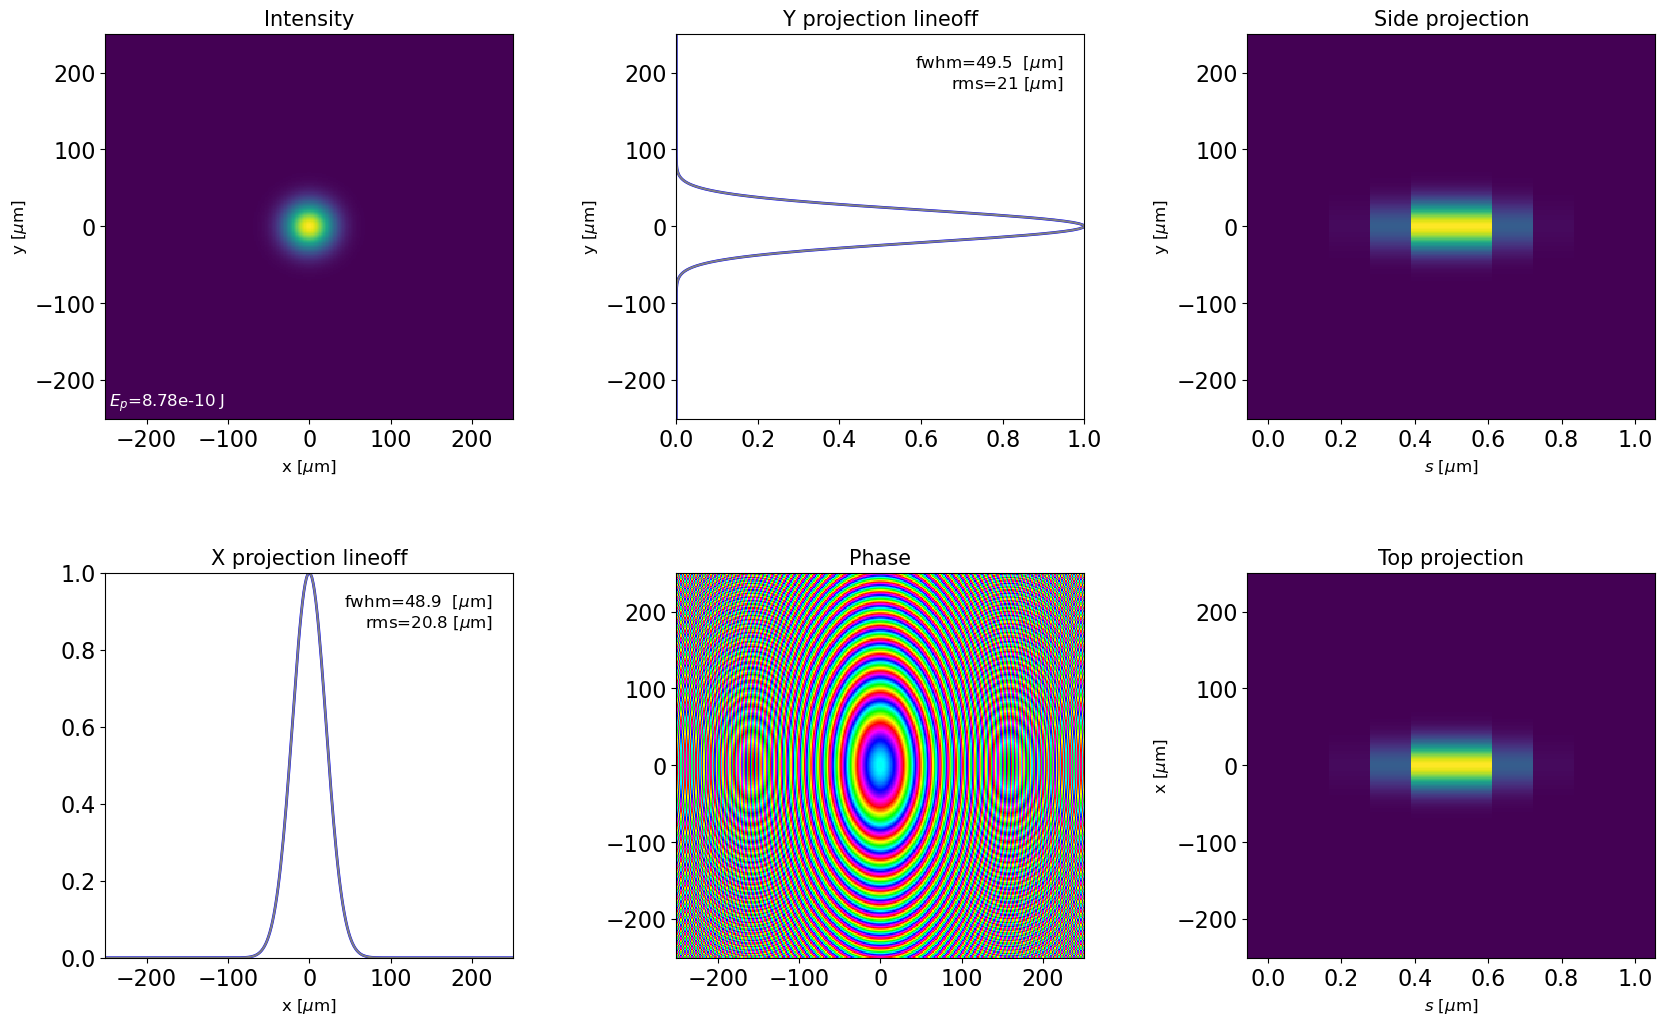

In [4]:
help(plot_dfl)

plot_dfl(dfl, #RadiationField() object
         domains=None, #longitudinal domain + transverse domain ('t' or 'f' + 's' or 'k') 
                       #(example: 'tk' - time/inversespace domain)
         z_lim=[],     #sets the boundaries to CUT the dfl object in z to ranges of e.g. [2,5] um or nm depending on freq_domain=False of True
         xy_lim=[],    #sets the boundaries to SCALE the dfl object in x and y to ranges of e.g. [2,5] um or urad depending on far_field=False of True
         figsize=4,    #rescales the size of the figure
         cmap='viridis',    #colormap which will be used for plotting (http://matplotlib.org/users/colormaps.html)
         phase=True,   #bool type variable, can replace Z projection or spectrum with phase front distribution z dimensions correspondingly
         fig_name='default_dfl_plot', #the desired name of the output figure, would be used as suffix to the image filename if savefig==True
         auto_zoom=False,  #bool type variable, automatically scales xyz the images to the (1%?) of the intensity limits
         column_3d=True,   #bool type variable, plots top and side views of the radiation distribution
         savefig=False,    #bool type variable, allow to save figure to image (savefig='png' (default) or savefig='eps', etc...)
         showfig=True,     #bool type variable, allow to display figure (slower)
         return_proj=False,#bool type variable, returns [xy_proj,yz_proj,xz_proj,x,y,z] array.
         line_off_xy=True, #bool type variable, if True, the transverse size of radiation are calculated at x=0 and y=0 position, otherwise marginal distributions are provided
         log_scale=0,      #bool type variable, if True, log scale will be used for potting
         cmap_cutoff=0)   #0 <= cmap_cutoff <= 1; all pixels that have intensity lower than cmap_cutoff will be seted to white color

Plotting radiation in inverse space - frequency domain

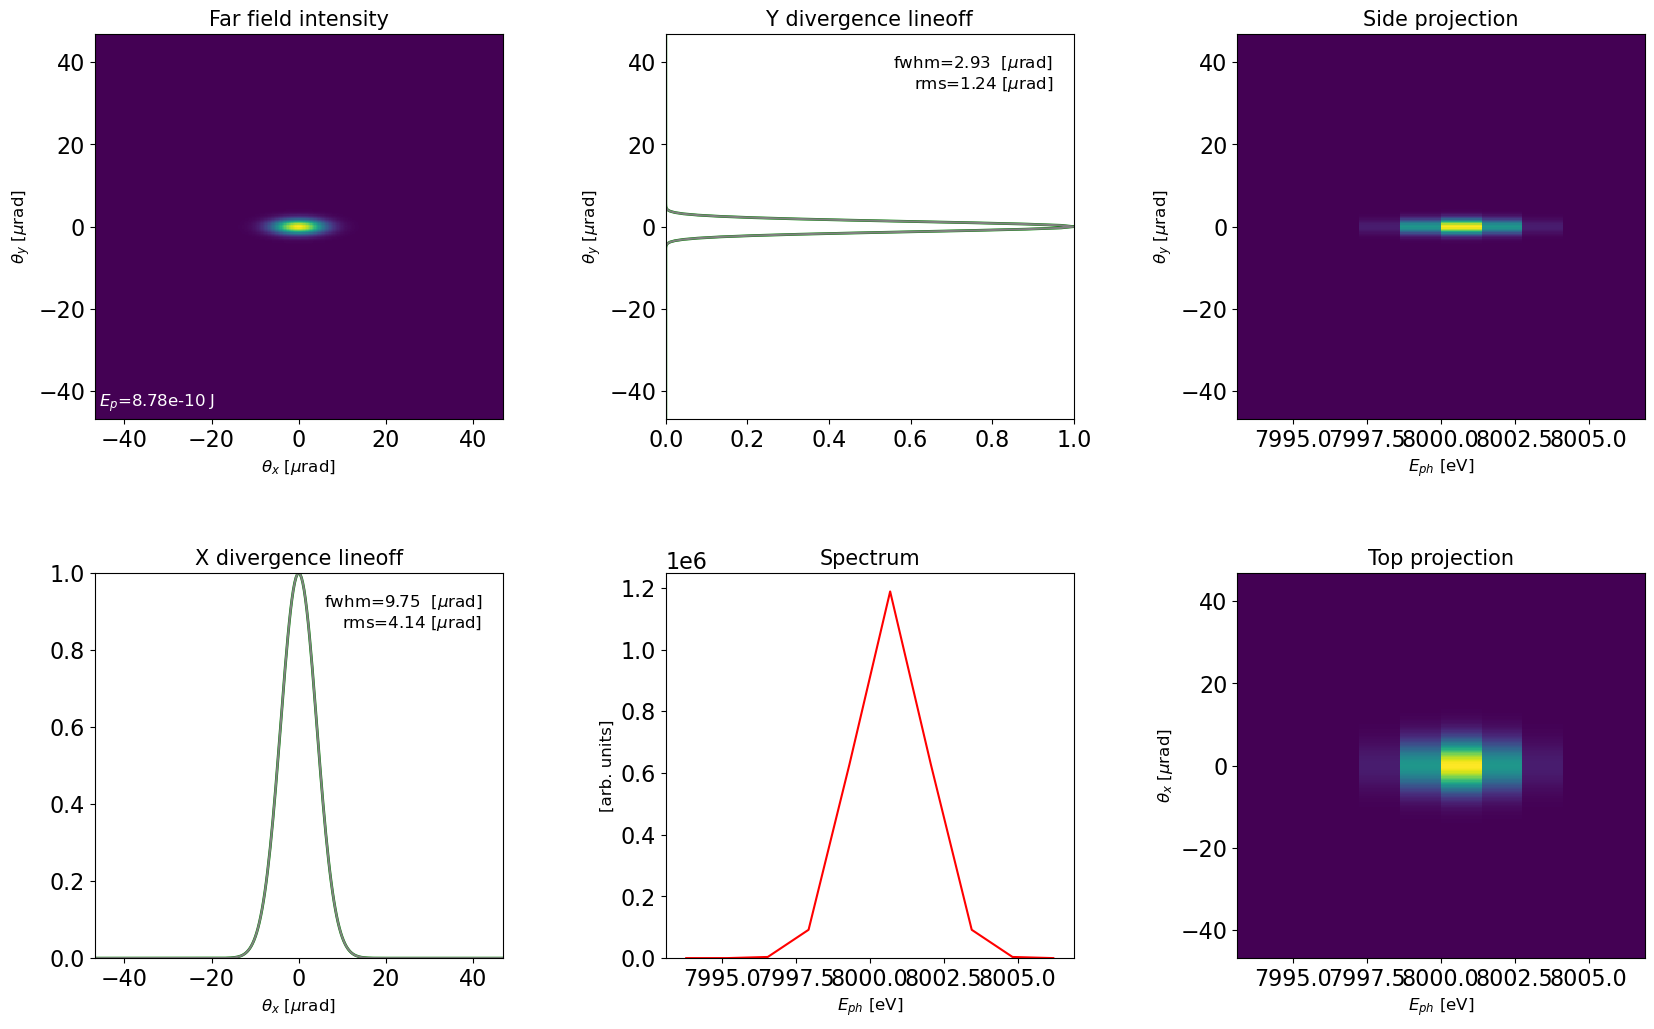

In [5]:
plot_dfl(dfl, domains='kf')

<a id='focus_radiation_field'></a>
## Focusing
Apply additional curvature to the radiation field wavefront along the given plane: 'x' or 'y'
Here we collimate the radiation in 'x' direction. Note the different radius of curvature needed to collimate the beam, compared to the distance from the waist in Gaussian beam.

Help on method curve_wavefront in module ocelot.optics.wave:

curve_wavefront(r=inf, plane='xy', domain_z=None) method of ocelot.optics.wave.RadiationField instance
    introduction of the additional
    wavefront curvature with radius r
    
    r can be scalar or vector with self.Nz() points
    r>0 -> converging wavefront
    
    plane is the plane in which wavefront is curved:
        'x' - horizontal focusing
        'y' - vertical focusing
        'xy' - focusing in both planes
    
    domain_z is the domain in which wavefront curvature is introduced
        'f' - frequency
        't' - time
        None - original domain (default)



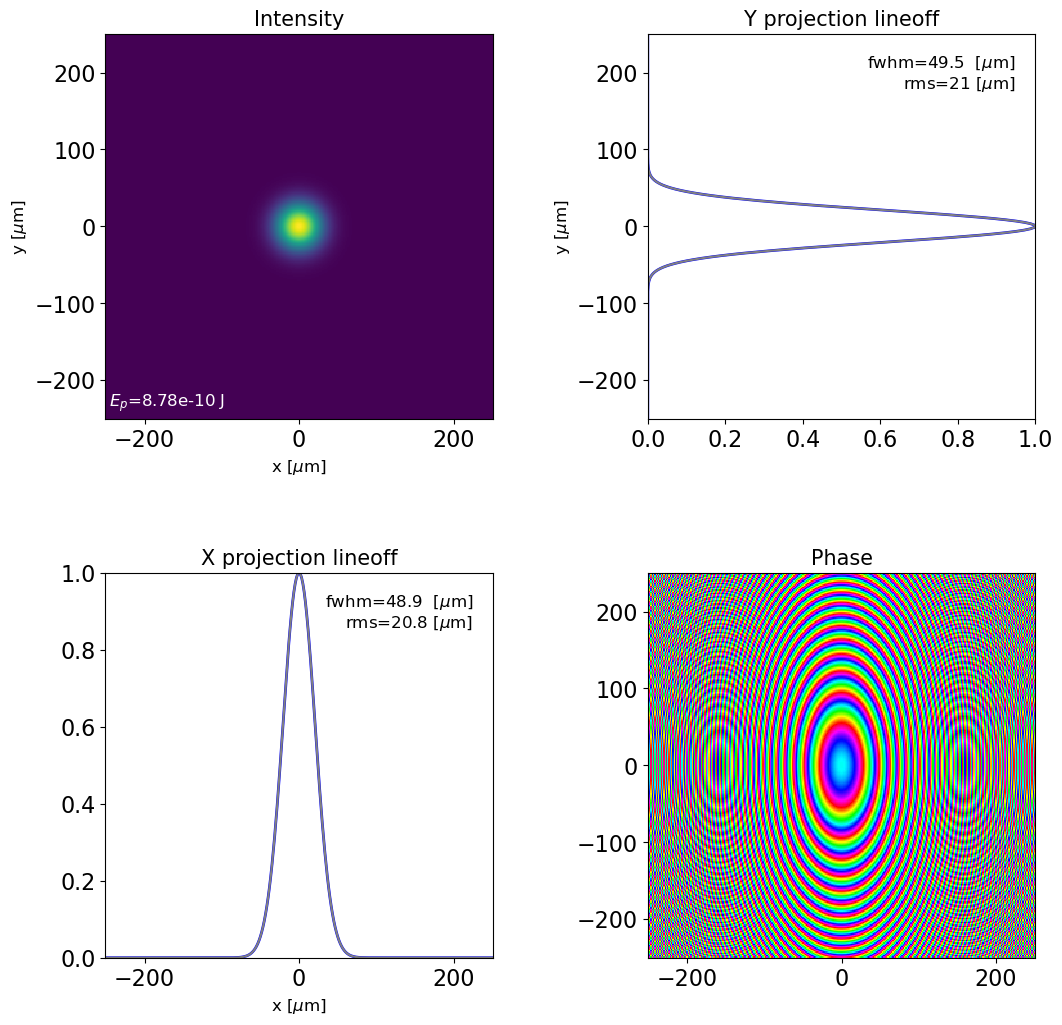

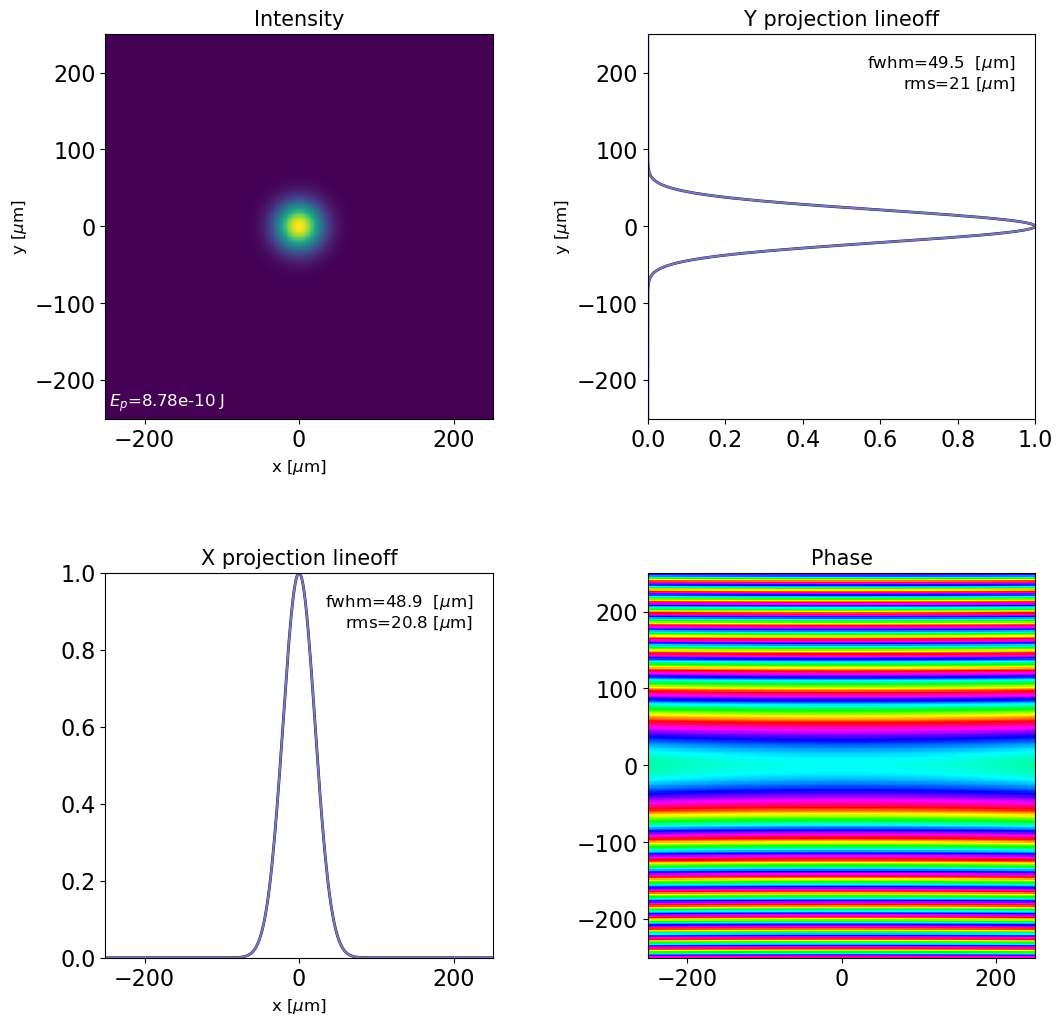

In [6]:
help(RadiationField().curve_wavefront)

dfl0 = deepcopy(dfl)
plot_dfl(dfl0, column_3d=False, phase=True)
dfl0.curve_wavefront(r=5.1, plane='x')
plot_dfl(dfl0, column_3d=False, phase=True)

<a id='prop_radiation_field'></a>
## Propagating

`RadiationField()` class has a  Fresnel Transfer Function Propagator method `RadiationField().prop(z, fine=1, return_result=0, return_orig_domains=1)` which calculates the radiation distribution at some distance `z` with the exact free space response function $H(k_x, k_y, z) = \exp\bigg[ik_0z\sqrt{1 - \cfrac{k^2_x}{k^2_0} - \cfrac{k^2_y}{k^2_0}} \bigg]$.

So that the field ad distance $z$ would be $E(x,y,z; t) = \mathscr{F}^{-1}\left\{\mathscr{F}\left\{E(x,y,0; t)\right\}H(k_x, k_y, z)\right\}$ (see e.g. *Voelz, David George. Computational fourier optics: a MATLAB tutorial. Bellingham, WA: SPIE press, 2011*)

The method accepts the following parameters:
* `z` - propagation distance [m]; z>0 corresponds to forward direction
* `fine` is an accuracy parameter. if `fine==0`, no Fourier transform to frequency domain is done, allows 2x faster calculation applicable for plain SASE radiation.
* `return_orig_domains` is `True` by default, otherwise, time is spared

We propagate the field to its horizontal waist.

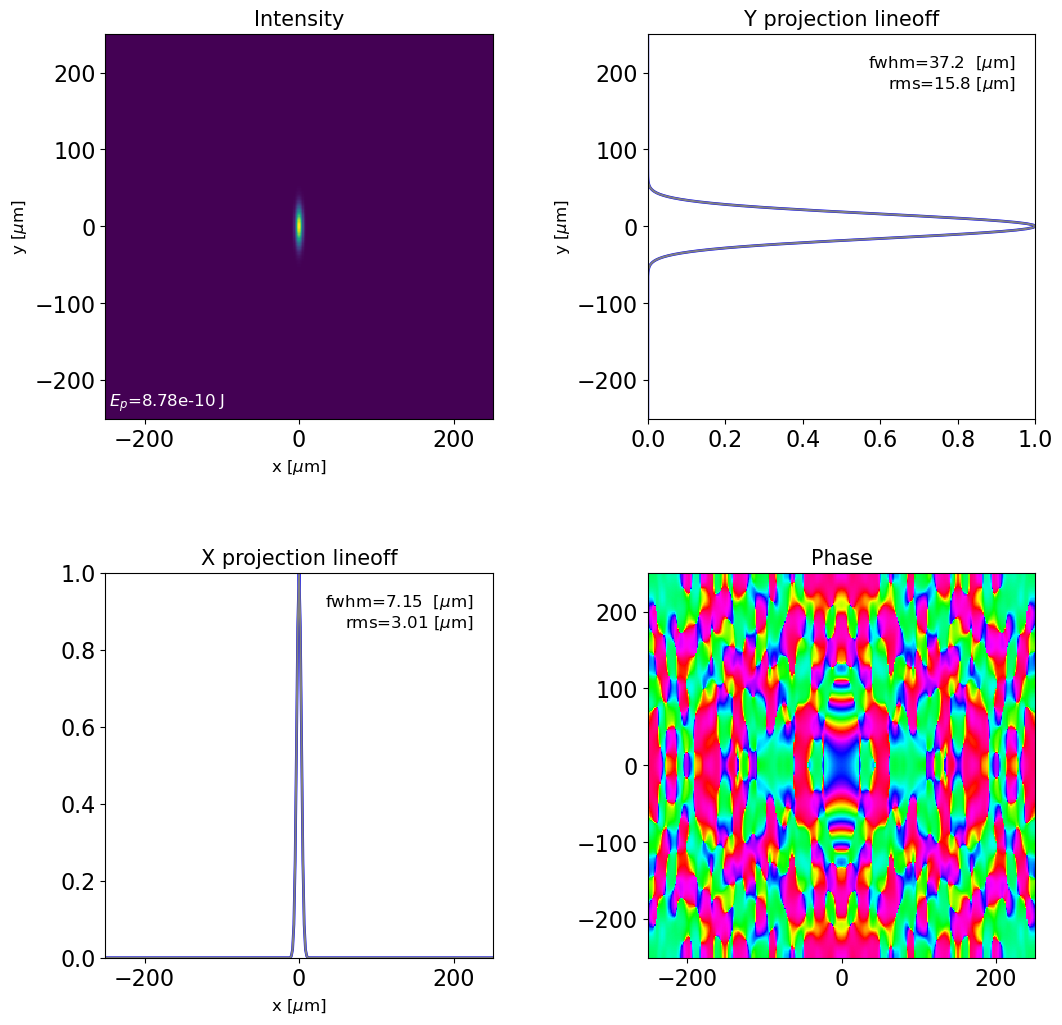

In [7]:
dfl0 = deepcopy(dfl)
dfl0.prop(z=-5) #propagation distance [m]
plot_dfl(dfl0, fig_name='dfl_prop', phase=True, column_3d=False)

One can change the grid spacing in the resulting plane upon propagation, using Angular-Spectrum Propagation with scaling parameter `m`, see *Schmidt, Jason Daniel. "Numerical simulation of optical wave propagation with examples in MATLAB" Bellingham, Washington, USA: SPIE, 2010*. Effectively it is done via manipulation of waverfont curvatures before and after the propagation.
The corresponding method `.prop_m(z, m=1, fine=1, return_result=0, return_orig_domains=1)` has an additional parameter
* `m` - the output mesh size in terms of input mesh size (m = L_out/L_inp). I can be a single number or a tuple `m=(m_x, m_y)` to account for asymmetric scaling.

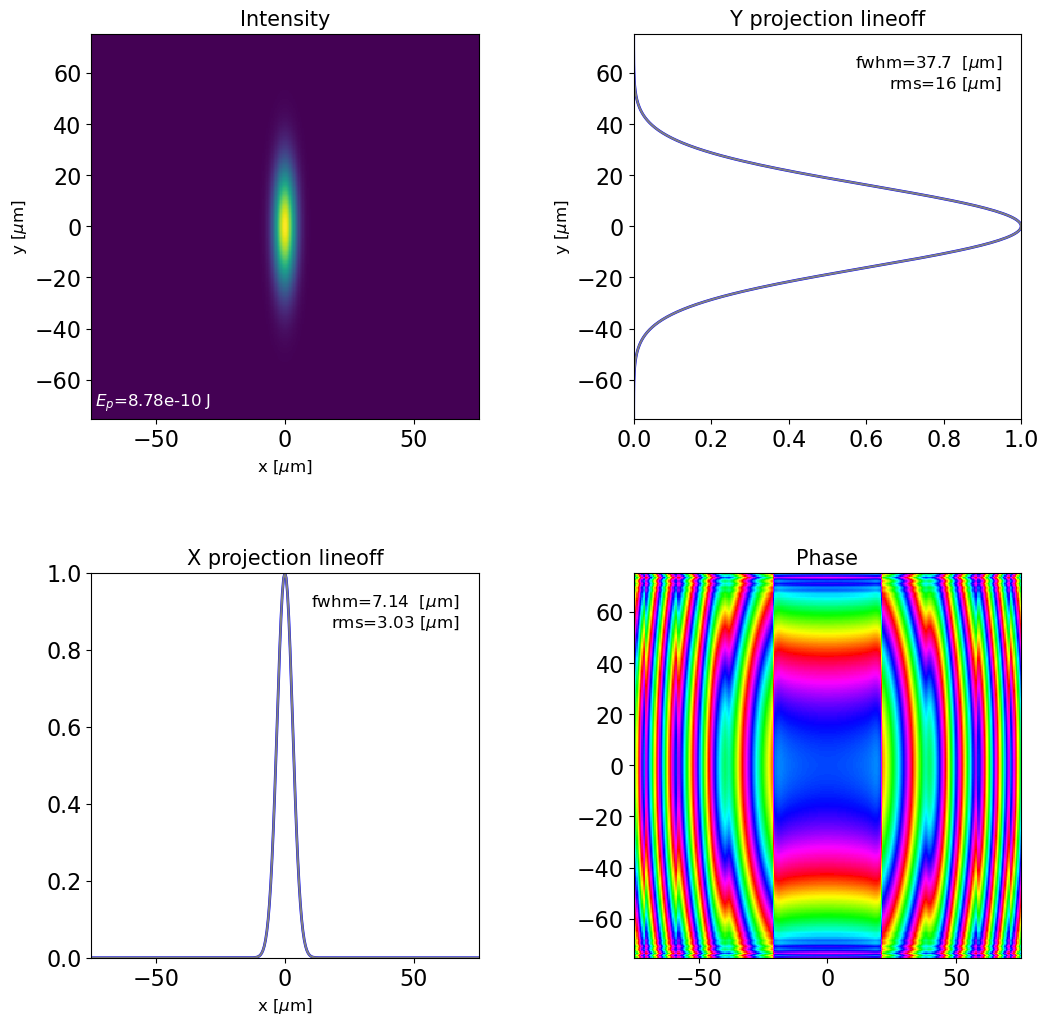

In [8]:
dfl0 = deepcopy(dfl)
dfl0.prop_m(z=-5, #propagation distance [m]
            m=0.3   #mesh resize coefficient
            #m=(0.05,0.3)   #asymmetric resize
            )
plot_dfl(dfl0, fig_name='dfl_prop', phase=True, column_3d=False)

The OCELOT toolkit has a function that scans transverse radiation size (fwhm, std), and power density (on-axis and maximum values) over the defined radiation propogation span with `.prop()` method. This may allow one to determine e.g. the location of the radiation source inside the undulator.

Help on function dfl_waistscan in module ocelot.optics.wave:

dfl_waistscan(dfl, z_pos, projection=0, **kwargs)
    propagates the RadaitionField object dfl
    through the sequence of positions z_pos
    and calculates transverse distribution parameters
    such as peak photon density and sizes in both dimensions
    
    if projection==1, then size of projection is calculated
        otherwise - size across the central line passing through the mesh center



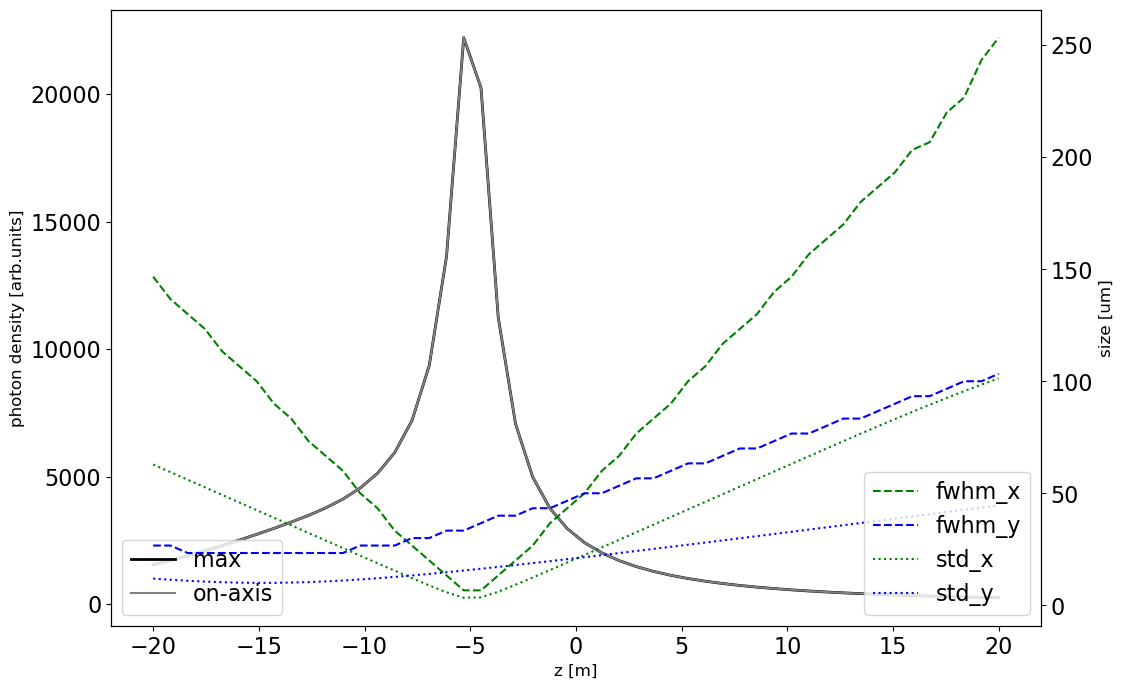

In [9]:
help(dfl_waistscan)
w_scan = dfl_waistscan(dfl, 
                       z_pos=np.linspace(-20,20,50), 
                       projection=0)

plot_dfl_waistscan(w_scan, 
                   fig_name='waist scan results', 
                   showfig=True, 
                   savefig=False)

<a id='dif_on_ap'></a>
## Aperturing

One can introduce a rectangular of a circular aperture and propagate the radiation through it.

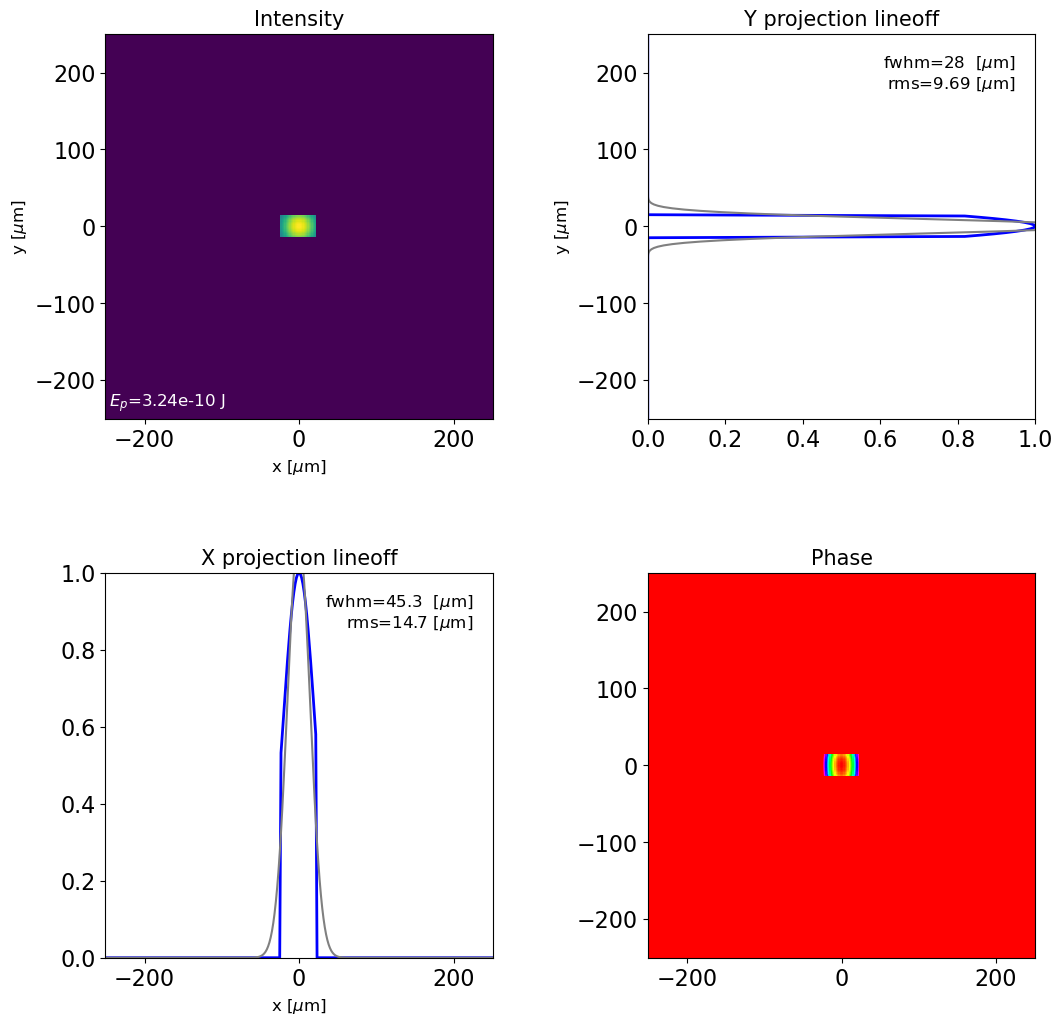

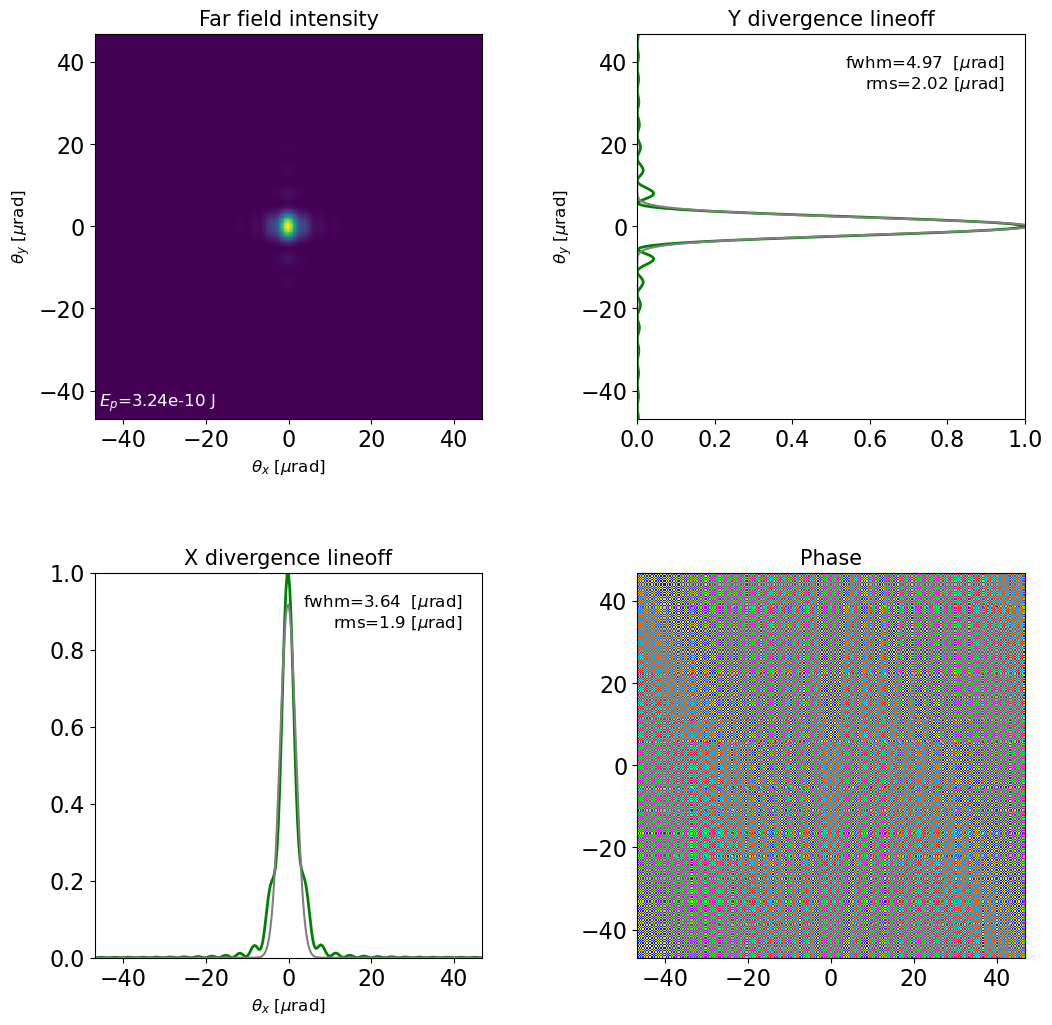

In [10]:
dfl0 = deepcopy(dfl)

dfl0 = dfl_ap_rect(dfl0, ap_x=5e-5, ap_y=3e-5) #x and y sizes in [m]
#dfl0 = dfl_ap_circ(dfl0, r=1e-5)

plot_dfl(dfl0, fig_name='dfl_ap', phase=True, column_3d=False)
#dfl0.prop_m(z=150, m=20)
#plot_dfl(dfl0, fig_name='dfl_ap_prop', phase=True, column_3d=False)
plot_dfl(dfl0, domains = 'kt', fig_name='dfl_ap_prop', phase=True, column_3d=False, log_scale=0)

<a id='dfl_interp'></a>
## Interpolating

RaidationField can be interpolated with `dfl_interp()` function.

When `newN` and `newL` are not None, `interpN` and `interpL` values are ignored.

Here `scipy.interpolate.interp2d` method is used

Help on function dfl_interp in module ocelot.optics.wave:

dfl_interp(dfl, interpN=(1, 1), interpL=(1, 1), newN=(None, None), newL=(None, None), method='cubic', return_result=1, **kwargs)
    2d interpolation of the coherent radiation distribution
    interpN and interpL define the desired interpolation coefficients for
    transverse point __density__ and transverse mesh __size__ correspondingly
    newN and newL define the final desire number of points and size of the mesh
    when newN and newL are not None interpN and interpL values are ignored
    coordinate convention is (x,y)

N_points before interpolation (Nz,Ny,Nx): (10, 301, 301)


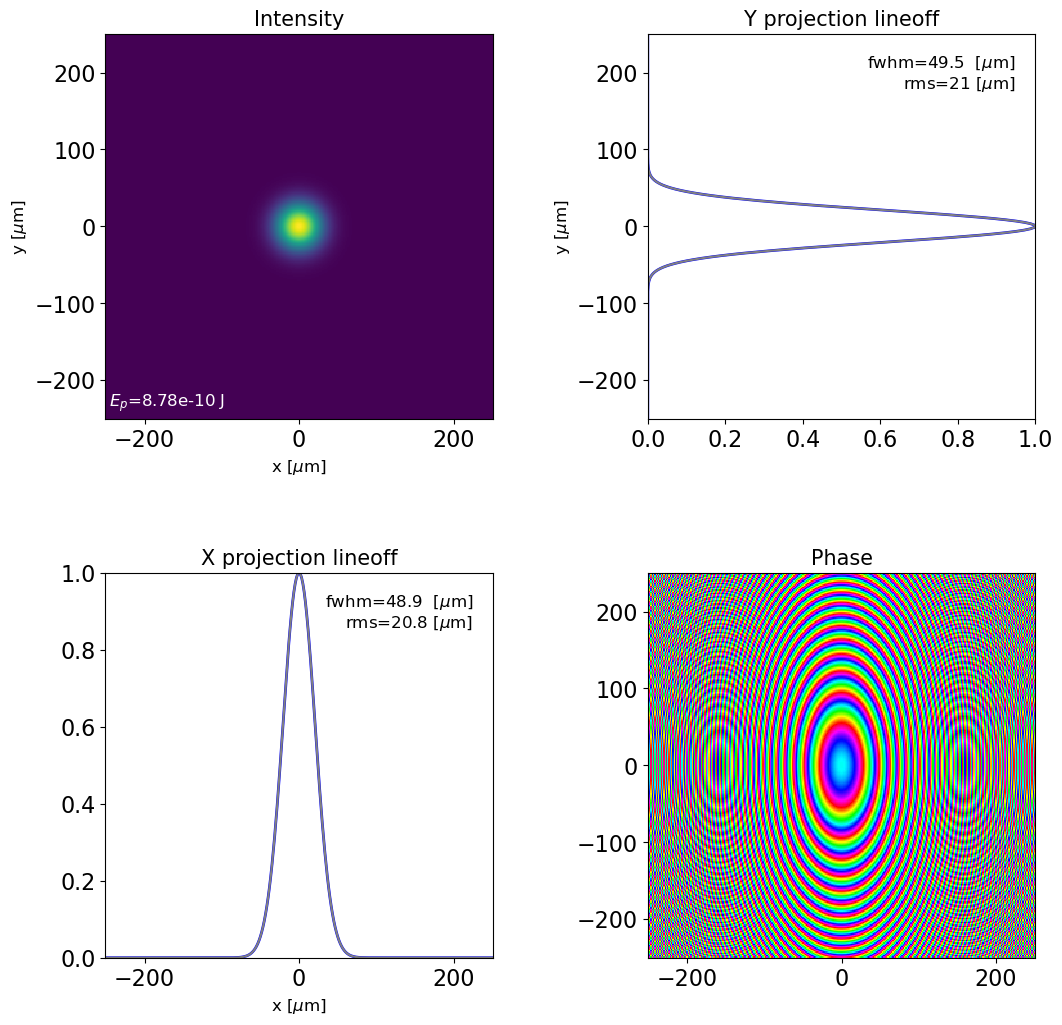

N_points after interpolation (Nz,Ny,Nx): (10, 151, 209)


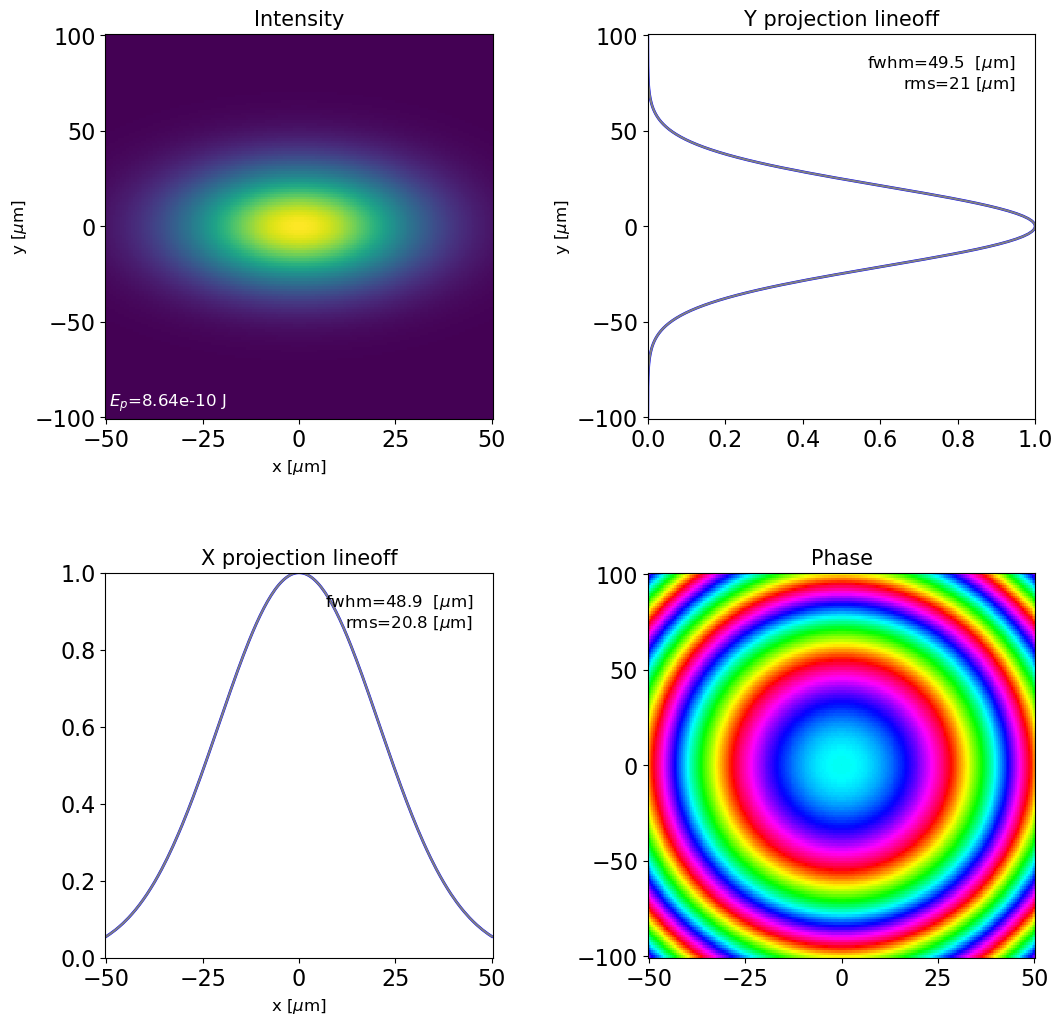

In [11]:
help(dfl_interp)

dfl0 = deepcopy(dfl)
print('N_points before interpolation (Nz,Ny,Nx): {:}'.format(dfl0.shape()))
plot_dfl(dfl0, domains = 'st', fig_name='not interpolated', phase=True, column_3d=False)

dfl0 = dfl_interp(dfl0, 
                  #interpN=(2, 0.5), #scaling the transverse point density (x,y)
                  #interpL=(1, 1), #scaling the transverse mesh (x,y)
                  newN=(209, 151), #new number of points (x,y)
                  newL=(100e-6, 200e-6), #new mesh size (x,y)
                  method='cubic', #interpolation method
                  return_result=1 #if 0 - mutates the object, if 1 - returns the result
                 )

print('N_points after interpolation (Nz,Ny,Nx): {:}'.format(dfl0.shape()))
plot_dfl(dfl0, domains = 'st', fig_name='interpolated', phase=True, column_3d=False)

<a id='SF_analysis'></a>
## Space-Frequency analysis and manipulation

<a id='Wigner'></a>
### Calculating on-axis Wigner distribution
let's generate a frequency-chirped radiation field

In [12]:
E_pohoton = 8000 #central photon energy [eV]
kwargs={'xlamds':(h_eV_s * speed_of_light / E_pohoton), #[m] - central wavelength
        'shape':(3,3,1000),           #(x,y,z) shape of field matrix (reversed) to dfl.fld
        'dgrid':(1e-6,1e-6,5e-6), #(x,y,z) [m] - size of field matrix
        'power_rms':(3e-6,3e-6,0.5e-6),#(x,y,z) [m] - rms size of the radiation distribution (gaussian)
        'freq_chirp':0.8,                #dw/dt=[1/fs**2] - requency chirp of the beam around power_center[2]
        }
dfl = generate_gaussian_dfl(**kwargs);  #Gaussian beam defenition

and calculate a Wigner distribution of the on-axis radiation with `wigner_dfl()` function

In [13]:
help(wigner_dfl)
wig = wigner_dfl(dfl,
                 pad=1 # pads the radiation field values with zeros to increase number of points in <pad> times
                )

Help on function wigner_dfl in module ocelot.optics.wave:

wigner_dfl(dfl, method='mp', pad=1, **kwargs)
    returns on-axis WignerDistribution from dfl file



Help on function plot_wigner in module ocelot.gui.dfl_plot:

plot_wigner(wig_or_out, z=inf, x_units='um', y_units='ev', x_lim=(None, None), y_lim=(None, None), downsample=1, autoscale=None, figsize=3, cmap='seismic', fig_name=None, savefig=False, showfig=True, plot_proj=1, plot_text=1, plot_moments=0, plot_cbar=0, log_scale=0, **kwargs)
    Plots wigner distribution (WD) with marginals
    
    :param wig_or_out: may be WignerDistribution() or GenesisOutput() object
    :param z: (if isinstance(wig_or_out, GenesisOutput)) location at which WD will be calculated
    :param x_units: [m or fs] units to display power scale
    :param y_units: [nm or eV] units to display spectrum scale
    :param x_lim: scaling limits for x in given units, (min,max) or [min,max], e.g: (None,6)
    :param x_lim: scaling limits for y in given units, (min,max) or [min,max], e.g: (None,6)
    :param downsample: speeds up plotting by displaying only 1/downsample**2 points
    :param autoscale: find x_lim and x_l

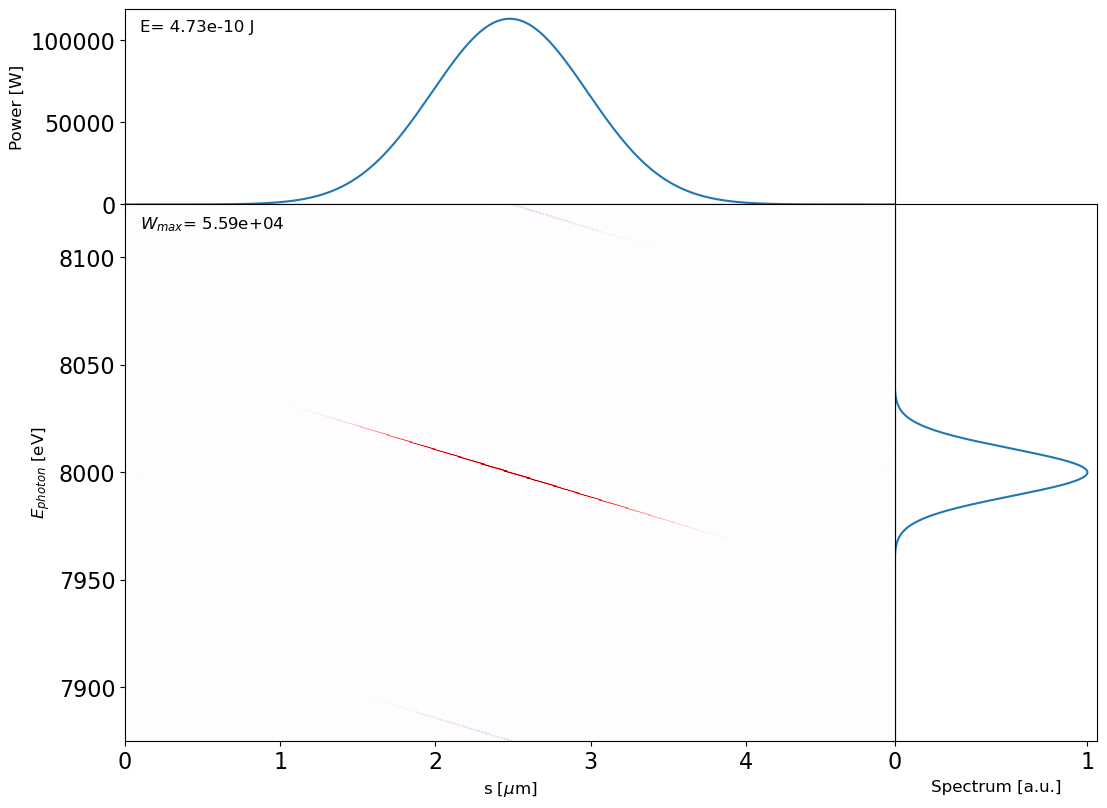

In [14]:
help(plot_wigner)
plot_wigner(wig, 
            x_units='um',
            y_units='ev',
            x_lim=(None, None),
            y_lim=(None, None),
            downsample=1,
            autoscale=None,
            figsize=3,
            cmap='seismic',
            fig_name=None,
            savefig=False,
            showfig=True,
            plot_proj=1, 
            plot_text=1,
            plot_moments=0,
            plot_cbar=0,
            log_scale=0,
            )

<a id='Compression'></a>
### Compress the chirped pulse

Help on function dfl_chirp_freq in module ocelot.optics.wave:

dfl_chirp_freq(dfl, coeff, E_ph0=None, return_result=False)
    The function adds a phase shift to a fld object. The expression for the phase see in the calc_phase_delay function
    dfl   --- is a fld object
    coeff --- coefficients in phase (see in the calc_phase_delay function)
    E_ph0 --- energy with respect to which the phase shift is calculated
    return_result --- a flag that is responsible for returning the modified dfl object if it is True or
                      change the dfl function parameter if it is False



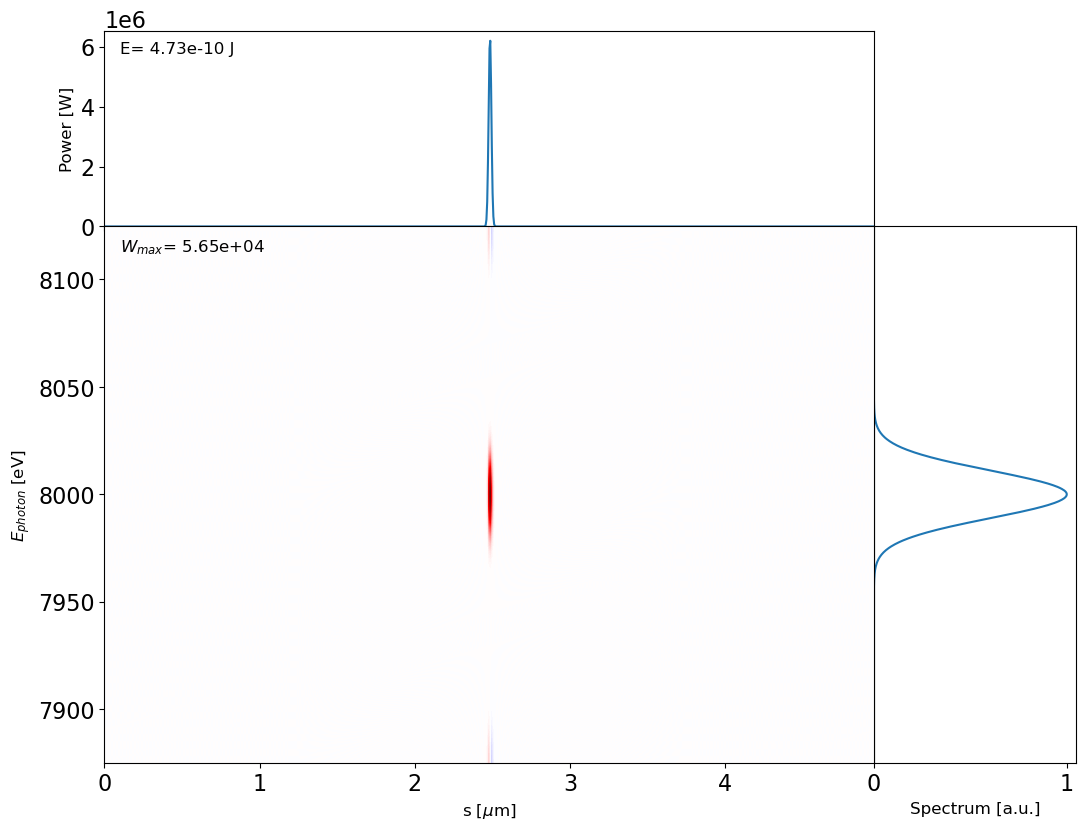

In [15]:
help(dfl_chirp_freq)

dfl_ch = dfl_chirp_freq(dfl, 
               coeff=(0, 0, 0.099), #coeff[2] is the group delay dispersion (GDD)
               E_ph0=None, 
               return_result=True)

plot_wigner(wigner_dfl(dfl_ch))

<a id='Spectrogram'></a>
### Calculating Spectrogtam

Help on function wigner_smear in module ocelot.optics.wave:

wigner_smear(wig, sigma_s)
    Convolves wigner distribution with gaussian window function to obtain spectrogram, see https://arxiv.org/pdf/1811.11446.pdf
    
    :param wig: ocelot.optics.wave.WignerDistribution object which will be convolved with generated window func
    :param sigma_s: [meters] rms size of the s=-ct the gaussian window func
    :return: convolved ocelot.optics.wave.WignerDistribution object with gaussian window function



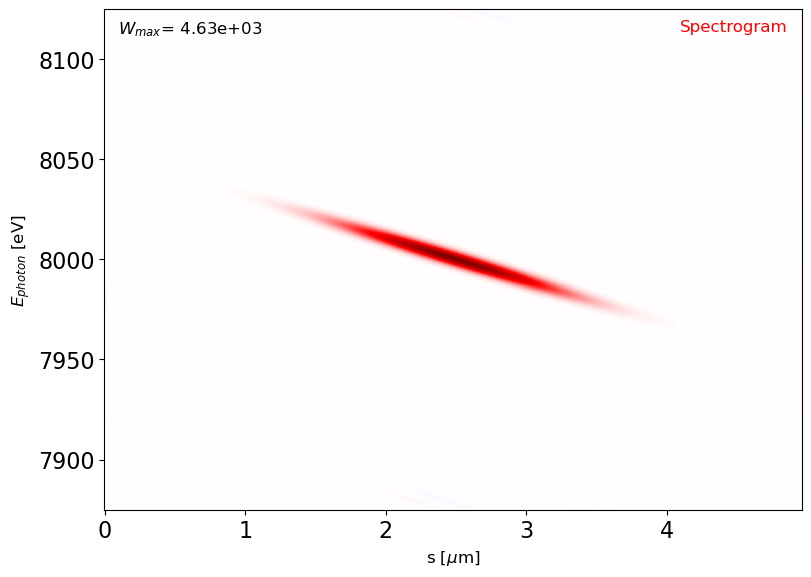

In [16]:
help(wigner_smear)
spectrogram = wigner_smear(wig, sigma_s=0.1e-6)
plot_wigner(spectrogram, figsize=2, plot_proj=0)